In [13]:
from skimage import io
import numpy as np
from PIL import Image as im
import seaborn as sn
import matplotlib.pyplot as plt
import math
from IPython.display import clear_output
from skimage.morphology import binary_dilation, square
from skimage.color import rgb2gray
import scipy.stats as st
import copy
import time

In [14]:
def display(img, title):
    io.imshow(img)
    plt.title('{}'.format(title))
    io.show()

In [15]:
def removeObject(object_list, img_gray):
    
    x, y = img_gray.shape
    filled_image = np.ones(img_gray.shape)
    for ob in object_list:
        filled_image[ob[0]:ob[1], ob[2]:ob[3]] = 0
    img_gray *= filled_image
    #for (x,y), v in np.ndenumerate(filled_image):
    #    if v == 0:
    # img_rgb[filled_image==0] = (0,0,0)
    
    io.imshow(img_gray)
    io.show()
    
    return filled_image, img_gray

In [16]:
# Unfilled Neighbors
def getUnfilledNeighbors(filled, filled_image_pad, kernel_size):

    # returns index list, one for each axis (x[], y[])
    unfilled = np.nonzero(binary_dilation(filled, square(3)) - filled) 

    # combine axis to get index of unfilled pixels (x,y)
    coord = list(zip(unfilled[0], unfilled[1])) 
    
    # get neighbor count for each unfilled pixel
    neighbors = []
    neighbors.append([np.sum(filled_image_pad[cd[0]:cd[0]+kernel_size, cd[1]:cd[1]+kernel_size]) for cd in coord])
    unfilled_pixels = [c for _, c in sorted(zip(neighbors[0], coord), reverse = True)]
    
    return unfilled_pixels

In [17]:
# Gaussian Kernel
def Gaussian2D(kernel_size, sigma):
    x = np.linspace(-sigma, sigma, kernel_size+1)
    kern1d = np.diff(st.norm.cdf(x))
    kern2d = np.outer(kern1d, kern1d)
    return kern2d/kern2d.sum()
    # x, y = np.meshgrid(np.linspace(-sigma, sigma, kernel_size), np.linspace(-sigma, sigma, kernel_size))
    # dst = np.sqrt(x*x + y*y)
    # mu = 0.0
    # gauss = np.exp(-( (dst-mu)**2 / ( 2.0 * sigma**2 ) ) )
    # return gauss/gauss.sum()

In [18]:
# Find Matches for each unfilles pixel
def FindMatches(pixel, template, patch_collection, filled_image_pad, kernel_size, sigma):
    '''
    validMask:      1s where Template is filled, 0s otherwise
    gaussMask:      2D Gaussian Kernel, same size as validMask
    templateMask:   gaussian weighted validMask
    totalWeight:    sum of values of templateMask
    reps:           total number of patches in patch_Collection
    dSSD:           normalized sum of squared differences
    '''
    
    validMask = filled_image_pad[pixel[0]:pixel[0]+kernel_size, pixel[1]:pixel[1]+kernel_size]
    gaussMask = Gaussian2D(kernel_size, sigma)
    templateMask = validMask * gaussMask
    totalWeight = np.sum(templateMask)
    # reps = patch_collection.shape[0]
    # template = np.repeat(template[np.newaxis,:,:], reps, axis = 0)
    # templateMask = np.repeat(templateMask[np.newaxis,:,:], reps, axis = 0)
    dSSD = templateMask * np.square(template - patch_collection)
    dSSD = np.sum(dSSD, axis=tuple(range(1,dSSD.ndim))) / totalWeight
    min_err = np.min(dSSD)
    
    bestMatches = [[i, d] for i, d in enumerate(dSSD) if d <= min_err*(1+errThreshold)]
    
    return bestMatches

In [19]:
# get example patches for image synthesis
def genPatches(img, filled_image, kernel_size):
    if len(img.shape) > 2:
        imgRows, imgCols, imgChannels = img.shape
    else:
        imgRows, imgCols = img.shape
    
    n_ex_rows = imgRows - (kernel_size - 1)
    n_ex_cols = imgCols - (kernel_size - 1)

    # initialise example Patches array
    patch_collection = np.zeros((n_ex_rows*n_ex_cols, kernel_size, kernel_size))

    for r in range(n_ex_rows):
        for c in range(n_ex_cols):
            if 0 in filled_image[r:r+kernel_size, c:c+kernel_size]:
                continue
            else:
                patch_collection[r*n_ex_cols + c] = img[r:r+kernel_size, c:c+kernel_size]
    
    return patch_collection

In [20]:
#read sample image
def readImage(image, disp = False):
    img = io.imread('./'+image)
    img_gray = rgb2gray(img)
    
    if disp == True:
        display(img, "Read Image-{}".format(image.split('/')[1]))

    return img, img_gray

In [24]:
imageFolder = 'Assignment-II-images-1'
outFolder = './synImages/'
images = ['test_im3.jpg'] #, 'test_im2.bmp']
# masks = ['masktest_im3.jpg']
kernel_size = [9]
errThreshold = 0.1
maxErrThreshold = 0.3
seed_size = 3
disp = False
f = open(outFolder+'log_3.txt', "w")
f.close()

In [25]:
blocks = ['person', 'sign', 'ground']
#person
person_coord = [(352,485,222,253)]
#sign
sign_coord = [(513,567,770,830),(566,664,788, 803)]
#ground
ground_coord = [(630, 664,3,390), (600, 630, 3, 435), (570,600,95,490), (540,570, 190,530),(510,540, 283, 570), (480, 510, 390, 610), (465,480, 465, 630),(440,465, 515,660)]

remove_blocks = [person_coord, sign_coord, ground_coord]

 Image = test_im3.jpg, block = ground, kernel = 9, pixels_left = 0.0


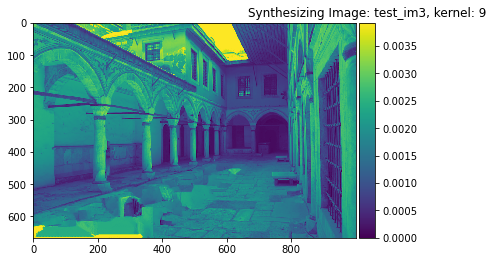

Completed: test_im3, Block: ground, kernel size: 9


In [26]:
for img_file in images:
    image = imageFolder+'/'+img_file
    img, img_gray = readImage(image, disp)

    output_dimx, output_dimy = np.shape(img_gray)
    # print("Output Dimension: ({},{})".format(output_dimx, output_dimy))
    total_pixels = output_dimx * output_dimy
    # pixel values are in the range 0 to 1
    img_rgb = img/255.0
    img_gray = img_gray/255.0
    synth_image = copy.copy(img_gray)

    for i in range(len(remove_blocks)):
        filled_image, synth_image = removeObject(remove_blocks[i], synth_image)
    
        for kernel in kernel_size:
            print("Processing: {}, Block: {}, kernel size: {}".format(img_file.split('.')[0], blocks[i], kernel))
            start = time.time() 
            samp_img = copy.copy(synth_image)   
            # display(synth_image, "Synthesized Image") 
            # print("Filled Image Dimension: ({},{})".format(filled_image.shape[0], filled_image.shape[1])) 
            # idx = np.nonzero(binary_dilation(filled_image, square(3)) - filled_image)
            # idx = list(zip(idx[0], idx[1]))
            # r = (idx[len(idx)-1][0]-idx[0][0])-1
            # c = (idx[len(idx)-1][1]-idx[0][1])-1
            # 
            # samp_img = synth_image[filled_image == 1]
            # samp_img = np.reshape(samp_img, (r,c))    
            # print("Sample Image Dimension: ({},{})".format(samp_img.shape[0], samp_img.shape[1]))
            # display(samp_img, "Sample Image") 
            filled_pixels = np.sum(filled_image)
            half_kernel = math.floor(kernel/2)
            sigma = kernel/6.4
            filled_image_pad = np.pad(filled_image, half_kernel, 'constant')
            synth_image_pad = np.pad(synth_image, half_kernel, 'constant')  
            patch_collection = genPatches(samp_img, filled_image, kernel)   
            while filled_pixels < total_pixels:
                progress = 0
                pixelList = getUnfilledNeighbors(filled_image, filled_image_pad, kernel)
                # pixelList, order = getUnfilledNeighbors(filled_image, filled_image_pad, kernel)
                for pixel in pixelList:
                    template = synth_image_pad[pixel[0]:pixel[0]+kernel, pixel[1]:pixel[1]+kernel]
                    bestMatches = FindMatches(pixel, template, patch_collection, filled_image_pad, kernel, sigma)
                    bestMatch = np.random.randint(0, len(bestMatches))
                    if bestMatches[bestMatch][1] < maxErrThreshold:
                        # synth_image[pixel[0], pixel[1]] = patch_collection[bestMatch, half_kernel, half_kernel]
                        synth_image[pixel[0], pixel[1]] = patch_collection[bestMatches[bestMatch][0], half_kernel, half_kernel]
                        synth_image_pad[pixel[0]+half_kernel, pixel[1]+half_kernel] = patch_collection[bestMatches[bestMatch][0], half_kernel, half_kernel]
                        filled_image[pixel[0], pixel[1]] = 1
                        filled_image_pad[pixel[0]+half_kernel, pixel[1]+half_kernel] = 1
                        filled_pixels += 1
                        progress = 1
                if progress == 0:
                    maxErrThreshold = maxErrThreshold * 1.1
                clear_output()
                # if (total_pixels-filled_pixels)/total_pixels % 10 == 0:
                print(" Image = {}, block = {}, kernel = {}, pixels_left = {}".format(img_file, blocks[i], kernel, total_pixels-filled_pixels)) 
                # if disp == True:
                display(synth_image, "Synthesizing Image: {}, kernel: {}".format(img_file.split('.')[0], kernel))   
            end = time.time()   
            print("Completed: {}, Block: {}, kernel size: {}".format(img_file.split('.')[0], blocks[i], kernel))

    # save synthesized image
    stat = io.imsave(outFolder+'Efros_'+blocks[i]+'.jpg', synth_image*255.0)
    # final_image = im.fromarray(np.uint8(synth_image*255))
    # final_image.save(outFolder+img_file.split('.')[0]+'_k'+str(kernel)+'.'+img_file.split('.')[1])
    # write log file
    writeLine = "File: {}, Kernel Size:{}, Time Taken:{} seconds\n".format(img_file, kernel, round(end-start,4))
    # append to the file
    with open(outFolder+"log_2.txt", "a") as f:
        f.write(writeLine)


In [27]:
stat = io.imsave(outFolder+'Efros_complete.jpg', synth_image*255.0)